# **1. Checking for Assumptions**

Loading and preparing the dataset

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# --- Global Seed Setup (type this once!) ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


In [2]:
# STEP 1: Load Libraries and Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Brouwer Mean Motion from Fengyun-2F CSV
df = pd.read_csv('/content/SARAL.csv')
df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('timestamp', inplace=True)

# --- Load and parse ground truth maneuver timestamps ---
truth_df = pd.read_excel("/content/cleaned_srlman.xlsx")
ground_truth_timestamps = pd.to_datetime(
    truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str)
)

# Select relevant column
bmm_series = df['Brouwer mean motion']


2. Checking Regualrity

In [3]:
# STEP 2: Resample to daily data
bmm_daily = bmm_series.resample('D').mean()

# Check missing values
missing_days = bmm_daily.isnull().sum()
print(f"Missing daily entries: {missing_days}")



Missing daily entries: 186


3. Interpolating missing values

In [4]:
# STEP 3: Fill gaps using linear interpolation
bmm_filled = bmm_daily.interpolate(method='linear')

bmm_filled = bmm_filled* 1e6

# Confirm fill
print("Any missing after interpolation?", bmm_filled.isnull().any())



Any missing after interpolation? False


4. Apply differencing

In [5]:
bmm_filled = bmm_filled.diff().dropna()
print("Differencing applied. First few values:")
print(bmm_filled.head())

Differencing applied. First few values:
timestamp
2013-03-11     0.019954
2013-03-12    -0.061371
2013-03-13    -0.061371
2013-03-14   -17.587114
2013-03-15     5.980038
Freq: D, Name: Brouwer mean motion, dtype: float64


In [6]:
# STEP 6: Check stationarity using ADF test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(bmm_filled.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("✅ The series is stationary (p < 0.05)")
else:
    print("❌ The series is NOT stationary (p ≥ 0.05)")


ADF Statistic: -29.42781329449985
p-value: 0.0
✅ The series is stationary (p < 0.05)


6. Checking Time gaps

In [7]:
# Ensure uniform time spacing
time_deltas = bmm_filled.index.to_series().diff().value_counts()
print("Time step distribution:")
print(time_deltas.head())


Time step distribution:
timestamp
1 days    3474
Name: count, dtype: int64


7. Visualisation

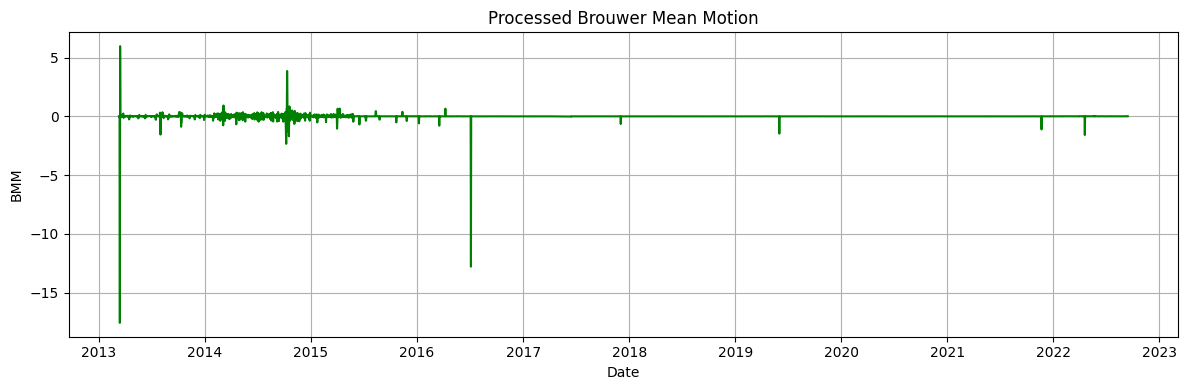

In [8]:
# STEP 8: Plot raw (interpolated + optionally differenced) BMM
plt.figure(figsize=(12, 4))
plt.plot(bmm_filled.index, bmm_filled.values, color='green')
plt.title("Processed Brouwer Mean Motion")
plt.ylabel("BMM")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


# **2. Fitting of XGBoost model**

In [9]:
!pip install optuna

In [10]:
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# --- Utility: Create lagged features ---
def make_lagged_features(series, lag=7):
    df_lagged = pd.DataFrame({'target': series})
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = series.shift(i)
    df_lagged.dropna(inplace=True)
    return df_lagged

# Dictionary to store Optuna studies and histories for each lag
lag_study_results = {}



In [11]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler

# --- Fix random seed for reproducibility ---
SEED = 42

# Store results for each lag
lag_study_results = {}

# Define lags to evaluate
lag_values = [5,10,15,20]

for LAG in lag_values:
    print(f"\n🚀 Running Optuna for LAG={LAG}")

    # --- Create lagged features ---
    lagged_df = make_lagged_features(bmm_filled, lag=LAG)

    # --- Train-test split ---
    train_size = int(len(lagged_df) * 0.8)
    train_df = lagged_df.iloc[:train_size]
    test_df = lagged_df.iloc[train_size:]

    X_train = train_df.drop('target', axis=1).values
    y_train = train_df['target'].values
    X_test = test_df.drop('target', axis=1).values
    y_test = test_df['target'].values

    # --- Define objective function for Optuna ---
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
            'random_state': SEED,
            'objective': 'reg:squarederror'
        }
        model = XGBRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

    # --- Create and run Optuna study with seeded sampler ---
    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    # --- Store results ---
    lag_study_results[LAG] = {
        "study": study,
        "best_params": study.best_params,
        "best_value": study.best_value
    }


[I 2025-08-14 15:24:38,339] A new study created in memory with name: no-name-83da7827-33f3-43f0-b8b1-6eabe69908cb



🚀 Running Optuna for LAG=5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 15:24:38,613] Trial 0 finished with value: 0.0054787386553650065 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.0054787386553650065.
[I 2025-08-14 15:24:40,888] Trial 1 finished with value: 0.005471029819654144 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.005471029819654144.
[I 2025-08-14 15:24:41,608] Trial 2 finished with value: 0.0055257385317932185 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'cols

[I 2025-08-14 15:24:51,028] A new study created in memory with name: no-name-42b42deb-5a95-44b1-93b2-175ea8aa1f84


[I 2025-08-14 15:24:51,014] Trial 49 finished with value: 0.005470886525382366 and parameters: {'n_estimators': 85, 'max_depth': 4, 'learning_rate': 0.009846557964982804, 'subsample': 0.9996860926484777, 'colsample_bytree': 0.811647696392076, 'gamma': 3.5551902937181947, 'reg_alpha': 0.34017281875159117, 'reg_lambda': 0.027271430713573186}. Best is trial 6 with value: 0.005461485516599147.

🚀 Running Optuna for LAG=10


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 15:24:51,464] Trial 0 finished with value: 0.005504458951391578 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.005504458951391578.
[I 2025-08-14 15:24:51,583] Trial 1 finished with value: 0.005479408608808362 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.005479408608808362.
[I 2025-08-14 15:24:51,738] Trial 2 finished with value: 0.005476719604928855 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

[I 2025-08-14 15:24:55,244] A new study created in memory with name: no-name-82e32be6-1bf0-4588-ab00-b46fb1ceae95


[I 2025-08-14 15:24:55,230] Trial 49 finished with value: 0.005479180978967868 and parameters: {'n_estimators': 192, 'max_depth': 5, 'learning_rate': 0.19330024073158603, 'subsample': 0.9997837678405108, 'colsample_bytree': 0.6687240962475142, 'gamma': 2.155321585597093, 'reg_alpha': 0.804497039322333, 'reg_lambda': 0.7217117908846454}. Best is trial 4 with value: 0.005464423102635153.

🚀 Running Optuna for LAG=15


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 15:24:55,299] Trial 0 finished with value: 0.005496248761112096 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.005496248761112096.
[I 2025-08-14 15:24:55,379] Trial 1 finished with value: 0.0054887118203254546 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.0054887118203254546.
[I 2025-08-14 15:24:55,439] Trial 2 finished with value: 0.005484812606519443 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsa

[I 2025-08-14 15:24:58,811] A new study created in memory with name: no-name-e558731e-f124-4310-bedb-fc38fa444890


[I 2025-08-14 15:24:58,796] Trial 49 finished with value: 0.006015703937318057 and parameters: {'n_estimators': 127, 'max_depth': 6, 'learning_rate': 0.19302735299947246, 'subsample': 0.6810394981349689, 'colsample_bytree': 0.8035296809041601, 'gamma': 0.5881366429435279, 'reg_alpha': 0.38804364816806736, 'reg_lambda': 0.13395066529531952}. Best is trial 4 with value: 0.005472741050564156.

🚀 Running Optuna for LAG=20


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-14 15:24:58,916] Trial 0 finished with value: 0.005510142568080607 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.035093904781414616, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 0.005510142568080607.
[I 2025-08-14 15:24:59,002] Trial 1 finished with value: 0.005496921640641925 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00011791655502618509, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 0.005496921640641925.
[I 2025-08-14 15:24:59,066] Trial 2 finished with value: 0.005518363743870489 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.0031763269920199078, 'subsample': 0.645614570099021, 'colsamp

In [12]:
print("\n📘 Summary of Optuna Results by Lag:\n")

for lag_val, result in lag_study_results.items():
    print(f"\n🌀 LAG = {lag_val}")
    print(f"Best MSE: {result['best_value']:.6f}")
    print("Best Parameters:")
    for k, v in result['best_params'].items():
        print(f"  {k}: {v}")





📘 Summary of Optuna Results by Lag:


🌀 LAG = 5
Best MSE: 0.005461
Best Parameters:
  n_estimators: 187
  max_depth: 4
  learning_rate: 0.23515992740571925
  subsample: 0.8875664116805573
  colsample_bytree: 0.9697494707820946
  gamma: 4.474136752138244
  reg_alpha: 0.5978999788110851
  reg_lambda: 0.9218742350231168

🌀 LAG = 10
Best MSE: 0.005464
Best Parameters:
  n_estimators: 66
  max_depth: 10
  learning_rate: 0.22783459357466163
  subsample: 0.9041986740582306
  colsample_bytree: 0.6523068845866853
  gamma: 0.48836057003191935
  reg_alpha: 0.6842330265121569
  reg_lambda: 0.4401524937396013

🌀 LAG = 15
Best MSE: 0.005473
Best Parameters:
  n_estimators: 66
  max_depth: 10
  learning_rate: 0.22783459357466163
  subsample: 0.9041986740582306
  colsample_bytree: 0.6523068845866853
  gamma: 0.48836057003191935
  reg_alpha: 0.6842330265121569
  reg_lambda: 0.4401524937396013

🌀 LAG = 20
Best MSE: 0.005471
Best Parameters:
  n_estimators: 66
  max_depth: 10
  learning_rate: 0.22783459

In [13]:
from xgboost import XGBRegressor

# --- Storage for final models and residuals ---
final_models = {}
residuals_per_lag = {}

# --- Loop over each lag from tuning history ---
for LAG, result in lag_study_results.items():
    print(f"\n📦 Retraining model on full data for LAG = {LAG}...")

    # Step 1: Recreate lagged dataframe
    lagged_df = pd.DataFrame({'target': bmm_filled})
    for i in range(1, LAG + 1):
        lagged_df[f'lag_{i}'] = bmm_filled.shift(i)
    lagged_df.dropna(inplace=True)

    # Step 2: Prepare full dataset
    X_full = lagged_df.drop("target", axis=1).values
    y_full = lagged_df["target"].values

    # Step 3: Load best parameters and create model
    best_params = result["best_params"].copy()
    best_params.update({
        "objective": "reg:squarederror",
        "random_state": SEED
    })

    model = XGBRegressor(**best_params)
    model.fit(X_full, y_full)

    # Step 4: Store model and residuals
    final_models[LAG] = model
    y_pred = model.predict(X_full)
    residuals = y_full - y_pred
    residuals_per_lag[LAG] = pd.Series(residuals, index=lagged_df.index)

    print(f"✅ Model trained and residuals saved for LAG = {LAG}")



📦 Retraining model on full data for LAG = 5...
✅ Model trained and residuals saved for LAG = 5

📦 Retraining model on full data for LAG = 10...
✅ Model trained and residuals saved for LAG = 10

📦 Retraining model on full data for LAG = 15...
✅ Model trained and residuals saved for LAG = 15

📦 Retraining model on full data for LAG = 20...
✅ Model trained and residuals saved for LAG = 20


# **3. Qualitative Analysis**

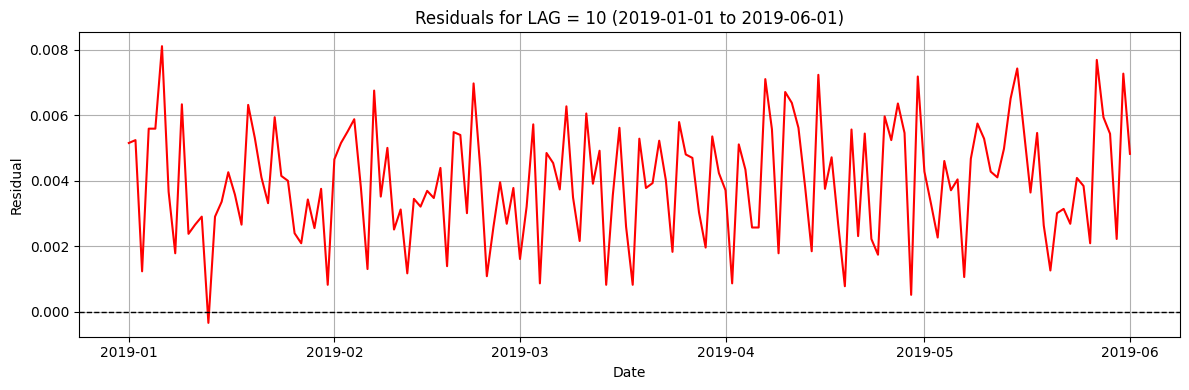

In [14]:
import matplotlib.pyplot as plt

def plot_residuals_for_lag(lag):
    """
    Plots residuals for a given lag using a fixed time window.

    Parameters:
        lag (int): The lag value whose residuals you want to visualize.
    """
    if lag not in residuals_per_lag:
        print(f"❌ Lag {lag} not found in residuals_per_lag.")
        return

    # Fixed time window
    start_date = "2019-01-01"
    end_date = "2019-06-01"

    # Get residuals and slice to window
    residual_series = residuals_per_lag[lag]
    residual_window = residual_series.loc[start_date:end_date]

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(residual_window.index, residual_window.values, color="red")
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.title(f"Residuals for LAG = {lag} ({start_date} to {end_date})")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_residuals_for_lag(10)


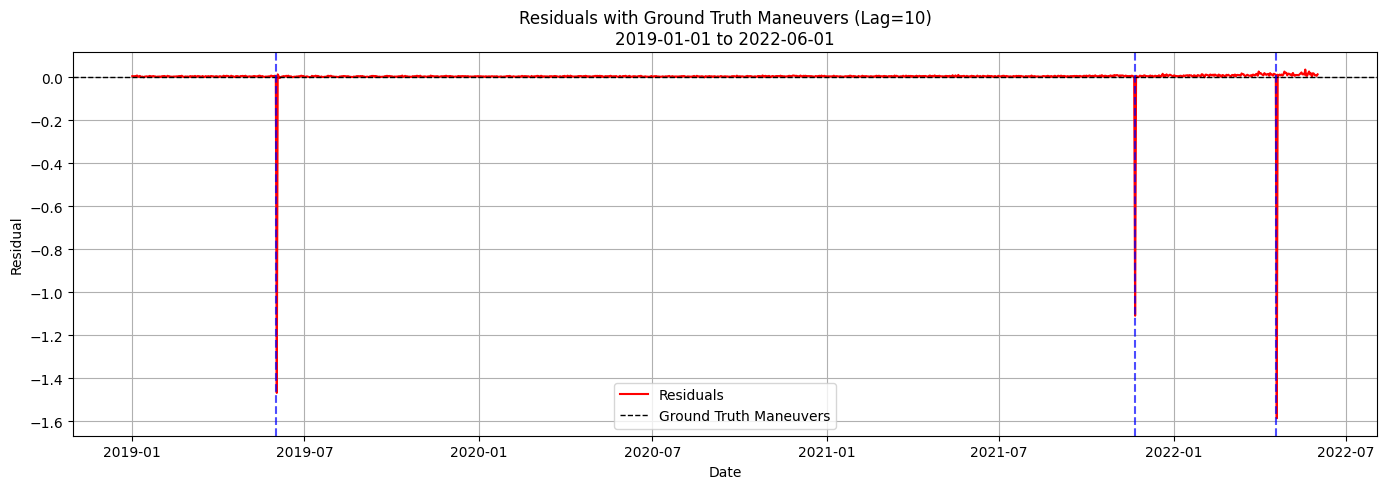

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and parse ground truth maneuver timestamps ---
truth_df = pd.read_excel("/content/cleaned_srlman.xlsx")
ground_truth_timestamps = pd.to_datetime(
    truth_df["Start Date"].astype(str) + " " + truth_df["Start Time"].astype(str)
)

# --- Define plot function for a given lag ---
def plot_residuals_with_gt_for_lag(lag):
    """
    Plot residuals with ground truth maneuver overlay for a given lag.
    Uses fixed time window from 2013-01-01 to 2013-03-01.
    """
    if lag not in residuals_per_lag:
        print(f"❌ Residuals not found for lag {lag}")
        return

    # Fixed time window
    start_date = "2019-01-01"
    end_date = "2022-06-01"

    # Get residuals for the specified lag
    residual_series = residuals_per_lag[lag]
    residual_window = residual_series.loc[start_date:end_date]

    # Filter ground truth maneuvers to the window
    gt_in_window = ground_truth_timestamps[
        (ground_truth_timestamps >= pd.to_datetime(start_date)) &
        (ground_truth_timestamps <= pd.to_datetime(end_date))
    ]

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(residual_window.index, residual_window.values, color='red', label='Residuals')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    for ts in gt_in_window:
        plt.axvline(ts, color='blue', linestyle='--', alpha=0.7)

    plt.title(f"Residuals with Ground Truth Maneuvers (Lag={lag})\n{start_date} to {end_date}")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.legend(["Residuals", "Ground Truth Maneuvers"])
    plt.tight_layout()
    plt.show()

# --- Example usage ---
plot_residuals_with_gt_for_lag(10)


# **4.Quantitative Analysis**

/tmp/ipython-input-2546430860.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # precision vs recall
/tmp/ipython-input-2546430860.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # precision vs recall
/tmp/ipython-input-2546430860.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # precision vs recall
/tmp/ipython-input-2546430860.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

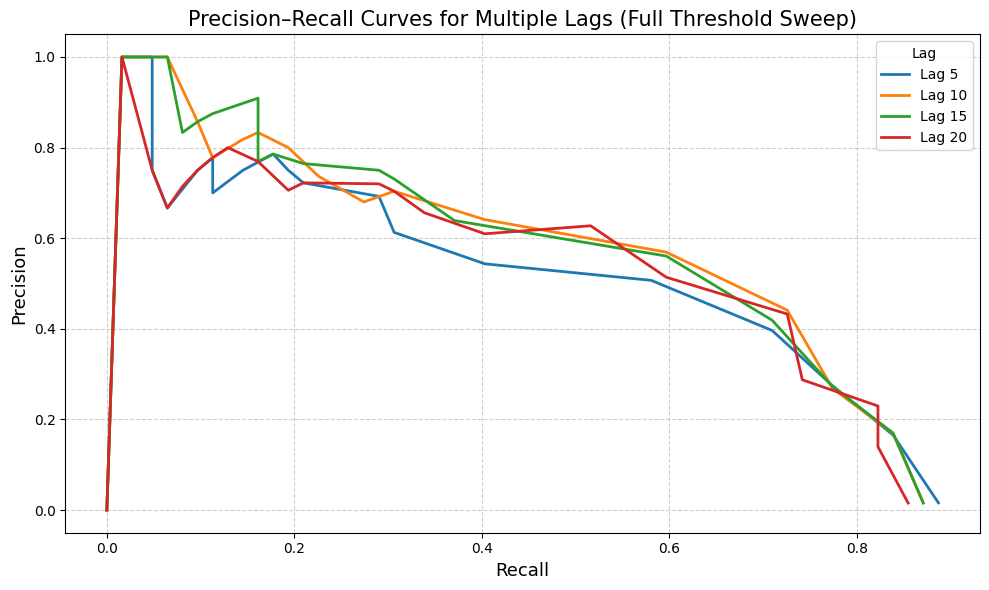

,Lag,Best Threshold,Precision,Recall,F1 Score,TP,FP,FN,PR AUC
0,10,0.343559,0.569231,0.596774,0.582677,37,28,25,0.528014
1,15,0.343534,0.560606,0.596774,0.578125,37,29,25,0.525234
2,20,0.373144,0.627451,0.516129,0.566372,32,19,30,0.492655
3,5,0.343505,0.507042,0.580645,0.541353,36,35,26,0.475931


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Precision / Recall / F1 Computation ---
def compute_prf_simple(
    residual_series: pd.Series,
    ground_truth_timestamps: pd.Series,
    threshold: float,
    matching_window_days: float = 3.0
):
    detections = residual_series[residual_series > threshold]
    detection_times = detections.index.sort_values()

    TP, FP, matched_gt = 0, 0, set()
    for det_time in detection_times:
        for i, gt_time in enumerate(ground_truth_timestamps):
            if i in matched_gt:
                continue
            if abs(det_time - gt_time) <= pd.Timedelta(days=matching_window_days):
                TP += 1
                matched_gt.add(i)
                break
        else:
            FP += 1

    FN = len(ground_truth_timestamps) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1, TP, FP, FN


# --- Evaluation and PR Plot ---
summary_rows = []
lag_metrics_dfs = {}  # Store metrics per lag for later scenario analysis
plt.figure(figsize=(10, 6))
matching_window_days = 3.0

for lag, residual_series in residuals_per_lag.items():
    abs_resid = residual_series.abs()

    # FULL RANGE sweep from min to max
    thresholds = np.linspace(
        abs_resid.min(),
        abs_resid.max(),
        150
    )

    pr_points = []
    metrics = []

    for threshold in thresholds:
        precision, recall, f1, TP, FP, FN = compute_prf_simple(
            abs_resid,
            ground_truth_timestamps,
            threshold,
            matching_window_days=matching_window_days
        )
        pr_points.append((recall, precision))
        metrics.append((threshold, precision, recall, f1, TP, FP, FN))

    # Convert to DataFrame to extract best row
    metrics_df = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "TP", "FP", "FN"])
    best_idx = metrics_df["F1"].idxmax()
    best_row = metrics_df.loc[best_idx]

    # Compute AUC using trapezoidal rule
    pr_points_arr = np.array(pr_points)
    sorted_idx = np.argsort(pr_points_arr[:, 0])  # sort by recall
    auc_pr = np.trapz(pr_points_arr[sorted_idx, 1], pr_points_arr[sorted_idx, 0])  # precision vs recall

    # Add to summary table
    summary_rows.append({
        "Lag": lag,
        "Best Threshold": best_row["Threshold"],
        "Precision": best_row["Precision"],
        "Recall": best_row["Recall"],
        "F1 Score": best_row["F1"],
        "TP": int(best_row["TP"]),
        "FP": int(best_row["FP"]),
        "FN": int(best_row["FN"]),
        "PR AUC": auc_pr
    })

    # Save full metrics for this lag
    lag_metrics_dfs[lag] = metrics_df.copy()

    # Plot PR curve
    plt.plot(pr_points_arr[:, 0], pr_points_arr[:, 1], label=f"Lag {lag}", linewidth=2)

# --- PR Curve Plot ---
plt.xlabel("Recall", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.title("Precision–Recall Curves for Multiple Lags (Full Threshold Sweep)", fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Lag", fontsize=10)
plt.tight_layout()
plt.show()

# --- Summary Table ---
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values("F1 Score", ascending=False).reset_index(drop=True)

from IPython.display import display
display(summary_df)
